In [1]:
# Common imports
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans

#NLP Libraries
#spacy libraries
import spacy as spacy
from spacy.lang.en import English # -> for tokenization
import spacy.lang.en.stop_words as stop_words # -> for removing the stopwords like he , she , why etc..

# nltk libraries
import nltk
from nltk.corpus import stopwords # -> for removing the stopwords like he , she , why etc..

#others dependencies
from collections import Counter # -> for counting the frequencies of the words

# Sklearn Models
# Model Imports

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# NN
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader


In [2]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset , DataLoader , RandomSampler

# optimizers imports
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import transformers
# similarity check library imports 
from sentence_transformers import SentenceTransformer, util

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f' Current device is {device} ')
sim_model  = SentenceTransformer('all-MiniLM-L6-v2').to(device)
model2 = SentenceTransformer('all-distilroberta-v1').to(device)
model3 = SentenceTransformer('multi-qa-mpnet-base-dot-v1').to(device)
model4 = SentenceTransformer('cardiffnlp/twitter-roberta-base-sentiment-latest').to(device)

 Current device is cuda 


No sentence-transformers model found with name C:\Users\pcdpm/.cache\torch\sentence_transformers\cardiffnlp_twitter-roberta-base-sentiment-latest. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\pcdpm/.cache\torch\sentence_transformers\cardiffnlp_twitter-roberta-base-sentiment-latest were not used when initializing RobertaModel: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
train_df = pd.read_excel('Dataset Problem statement 3.xlsx')
test_df = pd.read_excel('Unlabelled test datset.xlsx')
train_df.rename(columns = {'Product  ': 'product' , 'Verbatim Feedback ':'feedback','Job Role':'job','Sentiment (1=Positive & 0= Negative)':'y'}, inplace=True)
test_df.rename(columns = {'Product  ': 'product' , 'Verbatim Feedback ':'feedback','Job Role':'job'}, inplace=True)
train_df.head()

,product,job,feedback,y
0,IX,XYZ,There is no maintenance menu,0
1,IX,Architect,Very buggy.,0
2,IX,PQR,High quality - standards,1
3,IX,Sales Specialist,Features missing,0
4,IX,Architect,how to do the inter-working,0


In [5]:
joined_rows_t = []
joined_rows = []

for i in range(len(train_df['feedback'])):
    line = list(train_df['product'])[i]+' '+list(train_df['job'])[i]+' '+list(train_df['feedback'])[i]
    joined_rows.append(line)

for i in range(len(test_df['feedback'])):
    line = list(test_df['product'])[i]+' '+list(test_df['job'])[i]+' '+list(test_df['feedback'])[i]
    joined_rows_t.append(line)
    
print(f' Total length of the joined_rows : {len(joined_rows)}')
print(f' example : {joined_rows[0]}')

train_df['j_r'] = joined_rows
test_df['j_r'] = joined_rows_t

 Total length of the joined_rows : 387
 example : IX XYZ There is no  maintenance menu


In [6]:
print(train_df['product'].value_counts())
print(test_df['product'].value_counts())

QK = train_df[(train_df['product'] == 'QK') ]
IX = train_df[(train_df['product'] == 'IX') ]
DX = train_df[(train_df['product'] == 'DX') ]

QK    214
IX    106
DX     67
Name: product, dtype: int64
DX    130
Name: product, dtype: int64


In [632]:
def create_embeddings(df,model=model4):

    feedback = df['feedback'].tolist()
    msg_encoding = model.encode(feedback, convert_to_tensor = True)
    return msg_encoding

def split_test_train(x,y):
    train,val,y1,y2 = train_test_split(x,y,test_size=0.1,shuffle=True)
    return train,val,y1,y2

QK_emb = create_embeddings(df=QK)
IX_emb = create_embeddings(df=IX)
DX_emb = create_embeddings(df=DX)
test_emb = create_embeddings(df=test_df).to(device)


In [633]:
QK_emb.shape

torch.Size([214, 768])

In [634]:
QK_train , QK_val , QK_y1 , QK_y2 = train_test_split(QK_emb,QK['y'], test_size=0.1, shuffle=True, random_state=26)
IX_train , IX_val , IX_y1 , IX_y2 = train_test_split(IX_emb,IX['y'], test_size=0.1, shuffle=True, random_state=26)
DX_train , DX_val , DX_y1 , DX_y2 = train_test_split(DX_emb,DX['y'], test_size=0.1, shuffle=True, random_state=26)

train = torch.cat([QK_train,IX_train,DX_train],0).to(device)
val = torch.cat([QK_val,IX_val,DX_val],0).to(device)

y1 = torch.tensor(list(QK_y1)+list(IX_y1)+list(DX_y1)).type(torch.LongTensor).to(device)
y2 = torch.tensor(list(QK_y2)+list(IX_y2)+list(DX_y2)).type(torch.LongTensor).to(device)

print(train.shape,val.shape)

torch.Size([347, 768]) torch.Size([40, 768])


In [635]:
b_size = 12

train_dataloader = TensorDataset(train,y1)
train_dataloader = DataLoader(train_dataloader,batch_size=b_size, shuffle = True)

val_dataloader = TensorDataset(val,y2)
val_dataloader = DataLoader(val_dataloader,batch_size=b_size, shuffle=True)

In [636]:
# Fine Tuning the bert Model

class sentiment_classification(nn.Module):
    def __init__(self,input_dim):
        super(sentiment_classification,self).__init__()

        self.input = input_dim

        self.dense_layer_1 = nn.Sequential( # bert will output a vec of dim 768

            nn.Linear(self.input,512),
            nn.LayerNorm(512),
            nn.Dropout(0.5),
            nn.LeakyReLU(),

            nn.Linear(512,256),
            nn.LayerNorm(256),
            nn.LeakyReLU(),
            nn.Dropout(0.4),

            nn.Linear(256,32),
            nn.LayerNorm(32),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            # nn.Linear(128,64),
            # nn.BatchNorm1d(64),
            # nn.LeakyReLU(),
            # nn.Dropout(0.5),

            # nn.Linear(64,32),
            # nn.BatchNorm1d(32),
            # nn.ReLU(),
            # nn.Dropout(0.1),

            nn.Linear(32,16),
            nn.LayerNorm(16),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(16,4),
            nn.LayerNorm(4),
            nn.LeakyReLU(),
            nn.Dropout(0.1),

            nn.Linear(4,2),
        )

    def forward(self,x): # a_mask = attention mask
        #t1 = time.time()
        #t2 = time.time()
        x = self.dense_layer_1(x)
        #t3 = time.time()
        #print(f'Time taken for bert pass : {t2-t1} and d_l : {t3-t2} and r :{(t2-t1)/(t3-t2+1e-5):.2f}')
        #raise Exception(' Time check for bert pass ')

        return x

In [660]:
classification_model = sentiment_classification(768).to(device)
#print(classification_model)
print(f'Total trainable parameters in the model is : {sum(p.numel() for p in classification_model.parameters() if p.requires_grad)*1e-6:.3f} M')

Total trainable parameters in the model is : 0.536 M


In [661]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

class train_model():

    def __init__(self,model=classification_model,train_data=train_dataloader,val_data=val_dataloader,lr=1e-4):

        self.model = model
        self.val_data = val_data
        self.train_data = train_data
        self.loss = nn.CrossEntropyLoss(weight=torch.tensor([0.60,0.40]).to(device))
        self.optimizer = torch.optim.AdamW( self.model.parameters() , lr=lr , weight_decay=0.01)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=40)
    
    
    def eval(self):

        total_loss = torch.zeros((1)).to(device)
        y_pred = []
        truth_labels = []

        with torch.no_grad():

            for i,batch in enumerate(self.val_data) :
                k = self.model.eval()

                #batch = [x.to(device) for x in batch]  # moving the data to the GPU
                embed, labels = batch
                #labels = labels.type(torch.LongTensor).to(device)
                
                prediction = k(embed)
                Loss = self.loss(prediction,labels)

                total_loss = torch.add(total_loss,Loss,alpha=b_size)                    # Adding the loss here
                y_pred.append(prediction)                                                   # getting the predicted values
                truth_labels.append(labels)                                                 # storing the ground truth labels


        y_pred = torch.argmax(torch.cat(y_pred,0),1).detach().cpu().numpy()
        truth_labels = torch.cat(truth_labels,0).detach().cpu().numpy()

        score  = accuracy_score(truth_labels , y_pred)*100
        f1 = f1_score(truth_labels , y_pred)*100

        return total_loss.item(),score,f1 


    def train_model(self):

        total_loss = torch.zeros((1)).to(device)
        y_pred = []
        truth_labels = []

        for i,batch in enumerate(self.train_data) :

            #t1 = time.time()

            #batch = [x.to(device) for x in batch]  # moving the data to the GPU
            embed, labels = batch
            #labels = labels
            
            #t2 = time.time()

            prediction = self.model(embed)
            Loss = self.loss(prediction,labels)

            #t3 = time.time()

            self.optimizer.zero_grad()
            Loss.backward()              
            self.optimizer.step()         # changing the weights of the models using our optimizer
            self.scheduler.step()
            
            #t4 = time.time()

            total_loss = torch.add(total_loss,Loss,alpha=b_size) # Adding the loss here
            y_pred.append(prediction)        # getting the predicted values
            truth_labels.append(labels)      # storing the ground truth labels

            #t5 = time.time()
            #print(f' labels : {y_pred} and {truth_labels} and \n {Loss} ')
            #print(f' total time = {t5-t1} , {t5-t4} , {t4-t3} ,  {t3-t2} , {t2-t1}')
            #raise Exception(' Dimensionality check test - 1 in train')

        y_pred = torch.argmax(torch.cat(y_pred,0),1).detach().cpu().numpy()
        truth_labels = torch.cat(truth_labels,0).detach().cpu().numpy()

        #print(f"{Y_pred.shape}")
        #raise Exception(' Dimensionality check test - 1 in train')

        accuracy = accuracy_score(truth_labels , y_pred)*100
        f1 = f1_score(truth_labels , y_pred)*100

        return  total_loss.item() , accuracy , f1
    
    def train(self,epochs=5, print_freq=1): 
        val_loss_list, accuracy_val, f1_val, train_loss_list, accuracy_train , f1_train = [], [], [], [], [], []
        for e in tqdm(range(epochs)):
            
            #v_l, v_a, v_f = self.eval()
            t_l, t_a, t_f = self.train_model()
            v_l, v_a, v_f = self.eval()
            val_loss_list.append(v_l); accuracy_val.append(v_a); f1_val.append(v_f); train_loss_list.append(t_l); accuracy_train.append(t_a); f1_train.append(t_f)

            if (e+1) % print_freq == 0:

                print(f' ====================================================================================')
                print(f' Epoch {e}/{epochs} has been finished ')
                print(f' Avg train_loss of the epoch {e} is {t_l/len(train):.3f} ')
                print(f' Avg val_loss of the epoch {e} is {v_l/len(val):.3f} ')
                print(f' The accuracy of the train and val dataset for the epoch {e} is {t_a:.2f} and {v_a:.2f}')
                print(f' The f1 score of the train and val dataset for the epoch {e} is {t_f:.2f} and {v_f:.2f}')
                print(f' ==================================================================================== \n ')

        return train_loss_list, val_loss_list , f1_val, f1_train , accuracy_val, accuracy_train


In [664]:
Model1 = train_model()
outputs = Model1.train(5, print_freq = 20)
print(outputs[1], '\n', outputs[2] )

100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

[14.95510196685791, 15.69950008392334, 14.114540100097656, 16.924522399902344, 17.347091674804688] 
 [87.49999999999999, 90.9090909090909, 90.9090909090909, 90.9090909090909, 75.86206896551724]


In [494]:
import os

def log_outputs(name, out=outputs):

    df_dict = {'train_loss' : out[0], 'val_loss' : out[1], 'val_f1': out[2], 'train_f1': out[3], 'val_accuracy': out[4], 'train_accuracy': out[5], }
    header_needed = False if os.path.exists('./logs/'+name+'.csv') else True

    df = pd.DataFrame(df_dict).round(3)
    df.to_csv('./logs/'+name+'.csv', mode='a', header=header_needed, index=False)
        

In [495]:
log_outputs(name='all-distilroberta-v1-batchnorm-553e', out= outputs)

In [18]:
# test 

test_Dataloader = TensorDataset(test_emb)
test_Dataloader = DataLoader(test_Dataloader,batch_size=b_size)

y_pred = []
c = classification_model.eval()

for i,batch in tqdm(enumerate(test_Dataloader)):
    data = batch[0]
    prediction = c(data)
    y_pred.append(prediction)

prob = torch.max(nn.Softmax(dim=1)(torch.cat(y_pred,0)),1).values.detach().cpu().numpy()
y = torch.argmax(torch.cat(y_pred,0),1).detach().cpu().numpy()

test_df['y'] = y
test_df['conf'] = prob


9it [00:00, 582.43it/s]


In [19]:
test_df.head(15)

,product,job,feedback,Sentiment (1=Positive & 0= Negative),j_r,y,conf
0,DX,Operations,software releases are always late. Customer-fa...,NaN,DX Operations software releases are always lat...,0,0.681223
1,DX,Architect,documantation is wrong,NaN,DX Architect documantation is wrong,0,0.680318
2,DX,Sales Specialist,Nice platform- well managed- not perfect-,NaN,DX Sales Specialist Nice platform- well manage...,1,0.999329
3,DX,Architect,lack of features,NaN,DX Architect lack of features,0,0.682287
4,DX,Sales Specialist,Very good Support from BU,NaN,DX Sales Specialist Very good Support from BU,1,0.999897
5,DX,Sales Specialist,Nothing looks to be improved,NaN,DX Sales Specialist Nothing looks to be improved,1,0.844654
6,DX,Systems Engineer,Resiliency.,NaN,DX Systems Engineer Resiliency.,1,0.878539
7,DX,Architect,The BU has been very responsive,NaN,DX Architect The BU has been very responsive,1,0.984733
8,DX,Solutions,Good work done on this,NaN,DX Solutions Good work done on this,1,0.994135
9,DX,PrincipalabcArchitect,Good but has taken a long time to get feature ...,NaN,DX PrincipalabcArchitect Good but has taken a ...,1,0.999097


In [810]:
for j,i in enumerate(train_df['feedback']):
    if 'not good' in i:
        print(i,list(train_df['y'])[j],'-',list(train_df['job'])[j],'\n')

print(sum(list(test_df['y'])),sum(list(test_df['y']))/len(test_df)*100)

function is not good 0 - Support.CUSTOMER Executive 

54 41.53846153846154


In [638]:
test_df.to_csv(f'test-pred-{len(prev)}.csv')

In [811]:
test_df[test_df['y']==1].head(28)

,product,job,feedback,Sentiment (1=Positive & 0= Negative),y,conf,j_r
0,DX,Operations,software releases are always late. Customer-fa...,NaN,1,0.799668,DX Operations software releases are always lat...
1,DX,Architect,documantation is wrong,NaN,1,0.978319,DX Architect documantation is wrong
2,DX,Sales Specialist,Nice platform- well managed- not perfect-,NaN,1,0.991757,DX Sales Specialist Nice platform- well manage...
5,DX,Sales Specialist,Nothing looks to be improved,NaN,1,0.959371,DX Sales Specialist Nothing looks to be improved
6,DX,Systems Engineer,Resiliency.,NaN,1,0.957160,DX Systems Engineer Resiliency.
7,DX,Architect,The BU has been very responsive,NaN,1,0.585876,DX Architect The BU has been very responsive
8,DX,Solutions,Good work done on this,NaN,1,0.893217,DX Solutions Good work done on this
9,DX,PrincipalabcArchitect,Good but has taken a long time to get feature ...,NaN,1,0.997336,DX PrincipalabcArchitect Good but has taken a ...
12,DX,Architect,This has saved us. Glad to have these.,NaN,1,0.998488,DX Architect This has saved us. Glad to have t...
18,DX,XYZ,s/w quality is not as per standards,NaN,1,0.703458,DX XYZ s/w quality is not as per standards


In [812]:
#prev = []

In [813]:
prev.append(list(test_df[test_df['y']==1]['feedback']))

In [814]:
s1 = set(prev[-1])
s2 = set(prev[-3])
list(s2^s1)

[' release delayed.',
 'documantation is wrong ',
 'should aim to have feature parity',
 'Missing mcast scale, feature scale always an issue.Scale is always an issue with this platform.',
 'customer complain quaintly not good  ',
 'Not Support, very important to do the inter-working',
 'Evolution slowing down. Value differentiation eroding steadily vs industry in areas like broadband.',
 'Resiliency.',
 'Moderate service quality',
 'software releases are always late. Customer-facing product documentation is just a lazy',
 'The product line of commitments missing',
 'continued need for manageability features ',
 'less document',
 'Very good Support from BU',
 'Need new version',
 ' s/w quality is not as per standards']

In [815]:
s2-s1

{'Not Support, very important to do the inter-working',
 'Very good Support from BU'}

In [816]:
s1-s2

{' release delayed.',
 ' s/w quality is not as per standards',
 'Evolution slowing down. Value differentiation eroding steadily vs industry in areas like broadband.',
 'Missing mcast scale, feature scale always an issue.Scale is always an issue with this platform.',
 'Moderate service quality',
 'Need new version',
 'Resiliency.',
 'The product line of commitments missing',
 'continued need for manageability features ',
 'customer complain quaintly not good  ',
 'documantation is wrong ',
 'less document',
 'should aim to have feature parity',
 'software releases are always late. Customer-facing product documentation is just a lazy'}

In [817]:
test_df_flair = pd.read_csv('Test_Predictions_With_Confidence_Score 1.csv').rename(columns = {'Product  ': 'product' , 'Verbatim Feedback ':'feedback','Job Role':'job','Sentiment (1=Positive & 0= Negative)':'y'}, inplace=False)
test_df_flair.head()

,product,job,feedback,y,Sentiment_Score
0,DX,Operations,software releases are always late. Customer-fa...,negative,0.950495
1,DX,Architect,documantation is wrong,negative,0.886256
2,DX,Sales Specialist,Nice platform- well managed- not perfect-,positive,0.923906
3,DX,Architect,lack of features,negative,0.906721
4,DX,Sales Specialist,Very good Support from BU,positive,0.904810


In [818]:
test_df_flair['y'] = test_df_flair['y'].apply(lambda x: 1 if (x =='positive' or x == 1) else 0)
test_df_flair.head()

,product,job,feedback,y,Sentiment_Score
0,DX,Operations,software releases are always late. Customer-fa...,0,0.950495
1,DX,Architect,documantation is wrong,0,0.886256
2,DX,Sales Specialist,Nice platform- well managed- not perfect-,1,0.923906
3,DX,Architect,lack of features,0,0.906721
4,DX,Sales Specialist,Very good Support from BU,1,0.904810


In [819]:
test_df_flair[ test_df_flair['y'] == 1 ]

,product,job,feedback,y,Sentiment_Score
2,DX,Sales Specialist,Nice platform- well managed- not perfect-,1,0.923906
4,DX,Sales Specialist,Very good Support from BU,1,0.904810
6,DX,Systems Engineer,Resiliency.,1,0.828730
7,DX,Architect,The BU has been very responsive,1,0.921658
8,DX,Solutions,Good work done on this,1,0.918358
9,DX,PrincipalabcArchitect,Good but has taken a long time to get feature ...,1,0.797052
11,DX,Architect,Instability during customer qualification test...,1,0.884918
12,DX,Architect,This has saved us. Glad to have these.,1,0.911775
21,DX,Support,life changing product,1,0.872987
24,DX,Engineer,. need to improve or enhance,1,0.762941


In [820]:
s4 = set(list(test_df_flair[test_df_flair['y']==1]['feedback']))

In [821]:
s4-s1

{' Support more encapsulation options',
 'Complex product and feature matrix, customer needs babysitting  ',
 'Critical feature and certain multicasting',
 'Instability during customer qualification testing.',
 'Please automate  operations ',
 'Simple feature adds need to be tested thoroughly',
 'Solid product, but still very challenging competing',
 'Speaking about  the engg team has gone above and beyond Getting features committed ',
 'VERY COMPETITIVE AND ECONOMIC, FULL OF FEATURES',
 'Very good Support from BU',
 'code quality improving slowly'}

In [822]:
s1-s4

{' release delayed.',
 ' s/w quality is not as per standards',
 'Evolution slowing down. Value differentiation eroding steadily vs industry in areas like broadband.',
 'Missing mcast scale, feature scale always an issue.Scale is always an issue with this platform.',
 'Need new version',
 'Nothing looks to be improved',
 'The product line of commitments missing',
 'customer complain quaintly not good  ',
 'documantation is wrong ',
 'less document',
 'price and features are less improved ',
 'software releases are always late. Customer-facing product documentation is just a lazy'}

## Visualization

In [574]:
def plot_values(tit,vals):
    
    plt.figure(figsize=(17,11))
    plt.title(tit, size=17, color='black')

    plt.subplot(2,2,1)
    plt.plot(vals[0], label='train_loss', color='b')
    plt.plot(vals[1], label='val_loss', color='r')

    plt.xlabel('epochs', color='brown', size=15)
    plt.ylabel('loss', color='black', size=15)
    plt.title('train loss and val loss', size=17, color='black')
    plt.legend(loc='best')
    # plt.show()

    plt.subplot(2,2,2)
    plt.plot(vals[2], label='val_f1', color='r')
    plt.plot(vals[3], label='train_f1', color='b')

    plt.xlabel('epochs', color='brown', size=15)
    plt.ylabel('f1_score', color='black', size=15)
    plt.title('train f1 and val f1', size=17, color='black')
    plt.legend(loc='best')

    # plt.show()

    plt.subplot(2,2,3)
    plt.plot(vals[4], label='val_accuracy', color='r')
    plt.plot(vals[5], label='train_accuracy', color='b')

    plt.xlabel('epochs', color='brown', size=15)
    plt.ylabel('accuracy', color='black', size=15)
    plt.title('train and val accuracy', size=17, color='black')

    plt.legend(loc='best')
    plt.subplots_adjust( wspace=0.3, hspace=0.30)
    plt.show()

In [601]:
path = 'logs\\all-distilroberta-v1.csv'
df = pd.read_csv(path)

values = [ df[c].tolist() for c in df.columns ]

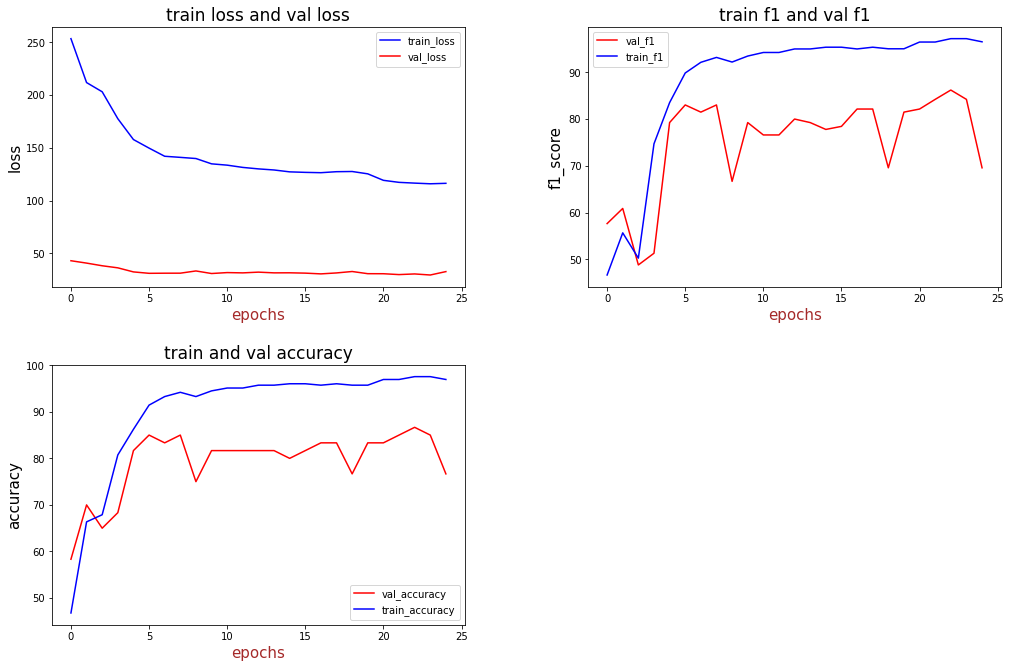

In [602]:
plot_values('twitter-roberta-base-sentiment',values)

## Correlation matrix

In [691]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [705]:
job_label = LabelEncoder()
prod_label = LabelEncoder()

onehot_j = OneHotEncoder()
onehot_p = OneHotEncoder()

In [706]:
corr_df = train_df.copy()
corr_df.columns

Index(['product', 'job', 'feedback', 'y', 'j_r'], dtype='object')

In [708]:
corr_df['prod'] = job_label.fit_transform(corr_df['product'])
onehot_j.fit_transform( corr_df['prod'] )

ValueError: Expected 2D array, got 1D array instead:
array=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [700]:
job_label.fit_transform(corr_df['job'])

ValueError: Expected 2D array, got 1D array instead:
array=['XYZ' 'Architect' 'PQR' 'Sales Specialist' 'Architect' 'XYZ'
 'Sales Specialist' 'PQR' 'XYZ' 'Support' 'Operations' 'Engineer' 'CXO'
 'Support' 'Support' 'Support' 'XYZ' 'PQR' 'PQR' 'XYZ' 'Architect'
 'Architect' 'Leader, Client Executive' 'Sales Specialist' 'Solutions'
 'Systems Engineer' 'XYZ' 'Architect' 'XYZ' 'PQR'
 'Business SolutionsArchitect' 'Systems Engineer' 'Architect' 'Architect'
 'Technical Solutions Specialist' 'Leader, Client Executive' 'Architect'
 'Systems Engineer' 'XYZ' 'PQR' 'Sales Business Development Manager'
 'Director, Regionalabc' 'XYZ' 'PQR' 'XYZ' 'Solutions' 'Sales Specialist'
 'Architect' 'Architect' 'PQR' 'Support' 'Support' 'Support' 'Engineer'
 'Operations' 'Engineer' 'Operations' 'Technical Leader' 'Support'
 'Engineer' 'Manager' 'CXO' 'Engineer' 'Manager' 'Support' 'Manager'
 'Technical Leader' 'Support' 'Manager' 'Leader, Customer Executive'
 'Engineer' 'Support' 'Support' 'Leader, Customer Executive' 'Support'
 'Manager' 'Support' 'Engineer [C]' 'Operations'
 'Leader, Customer Executive' 'Engineer' 'Business Development Manager'
 'XYZ' 'XYZ' 'Architect' 'XYZ' 'Sales Specialist' 'XYZ' 'Architect'
 'Architect' 'Architect' 'PQR' 'Architect' 'Systems Engineer' 'XYZ'
 'Systems Engineer' 'XYZ' 'PQR' 'Architect' 'Recruiting' 'Architect'
 'Systems Engineer' 'Leader, Client Executive' 'PQR' 'Architect'
 'Solutions' 'Architect' 'Architect' 'Architect' 'Director, Regionalabc'
 'Architect' 'PQR' 'Architect' 'Architect' 'XYZ' 'PQR'
 'Sales Business Development Manager' 'PQR' 'Architect' 'XYZ'
 'Sales Specialist' 'Solutions' 'Solutions' 'Leader, Client Executive'
 'Architect' 'XYZ' 'Solutions' 'Architect' 'Architect'
 'PrincipalabcArchitect' 'Sales Specialist' 'Support' 'Technical Leader'
 'Support' 'Support' 'Operations' 'Technical Leader' 'Engineer' 'Support'
 'High Touch Operations Manager' 'Support' 'CXO' 'Support'
 'High Touch Operations Manager' 'Engineer' 'Support' 'Support'
 'Operations' 'Engineer' 'XYZ' 'PQR' 'Leader, Regionalabc' 'Architect'
 'XYZ' 'Architect' 'Architect' 'Support' 'Support' 'Support' 'Engineer'
 'Support' 'Principal Engineer' 'Leader, Customer Executive' 'Support'
 'Support' 'Support' 'Manager' 'Manager' 'Technical Project Manager [C]'
 'Manager' 'Operations' 'Operations' 'Leader, Customer Executive'
 'Engineer' 'Support' 'Support' 'Engineer' 'Support' 'Architect'
 'Architect' 'XYZ' 'Architect' 'Sales Specialist' 'Architect'
 'Sales Specialist' 'Solutions' 'Systems Engineer' 'Architect' 'Engineer'
 'Support' 'Manager' 'Operations' 'Engineer - Network [C]' 'Manager'
 'Engineer' 'Manager' 'Project Manager [C]' 'Engineer'
 'Engineer - Consultant [C]' 'Engineer' 'Engineer - Customer Support [C]'
 'Services Manager' 'Customer Project Manager' 'Support' 'Support'
 'Manager' 'Support' 'Engineer - Network [C]' 'Manager' 'Architect.SALES'
 'SYSTEMS ENGINEER.SALES' 'MANAGER-REGIONAL.SALES'
 'MANAGER SYSTEMS ENGINEER.SALES' 'SALES SPECIALIST.SALES'
 'Architect.SALES' 'XYZ.SALES' 'Architect.SALES' 'Architect.SALES'
 'SYSTEMS ENGINEER.SALES' 'Architect.SALES' 'Architect.SALES'
 'Architect.SALES' 'MANAGER SYSTEMS ENGINEER.SALES'
 'Engineer.CUSTOMER Executive' 'ARCHITECT.CUSTOMER Executive'
 'Support.CUSTOMER Executive' 'Support.CUSTOMER Executive'
 'TECHNICAL LEADER.CUSTOMER Executive'
 'TECHNICAL LEADER.CUSTOMER Executive' 'Support.CUSTOMER Executive'
 'TECHNICAL LEADER.CUSTOMER Executive' 'Engineer.CUSTOMER Executive'
 'Engineer - Consultant' 'Support.CUSTOMER Executive'
 'Support.CUSTOMER Executive' 'Support.CUSTOMER Executive'
 'HIGH TOUCH OPERATIONS MANAGER.CUSTOMER Executive'
 'CUSTOMER PROJECT MANAGER.CUSTOMER Executive'
 'Support.CUSTOMER Executive' 'Architect' 'Architect' 'PQR' 'Architect'
 'Architect' 'Leader, Regionalabc' 'XYZ' 'Architect' 'Systems Engineer'
 'XYZ' 'Leader, Client Executive' 'Architect' 'Architect'
 'Sales Specialist' 'Solutions' 'Architect' 'XYZ' 'Leader,abc Specialist'
 'Leader, Client Executive' 'Architect' 'Architect' 'Architect'
 'Sales Specialist' 'Support' 'Support' 'Support'
 'Leader, Customer Executive' 'Leader, Customer Executive'
 'Leader, Customer Executive' 'Support' 'Support' 'Support' 'Support'
 'Support' 'Manager' 'Support' 'Support' 'Engineer' 'Engineer'
 'Technical Project Manager [C]' 'High Touch Operations Manager' 'Support'
 'Support' 'Support' 'Systems Engineer' 'Systems Admin [C]' 'XYZ'
 'Architect' 'Architect' 'Sales Specialist' 'Architect' 'Architect'
 'Architect' 'Solutions' 'Director, Regionalabc' 'Architect' 'Architect'
 'Systems Engineer' 'Architect' 'PQR' 'PQR' 'Architect' 'Architect'
 'PrincipalabcArchitect' 'Architect' 'XYZ' 'Architect' 'Systems Engineer'
 'XYZ' 'Architect' 'Account Representative [C]' 'Project Manager [C]'
 'Engineer - Network [C]' 'Engineer' 'Leader, Customer Executive'
 'Operations' 'Manager' 'Operations' 'Leader, Customer Executive'
 'Manager' 'Support' 'Operations' 'Support' 'Support'
 'Engineer - Consultant [C]' 'Engineer - Network [C]' 'Engineer'
 'Engineer - Test/QA [C]' 'Project Manager [C]' 'Support' 'Engineer'
 'Support' 'VIRTUALabc XYZ.SALES' 'SALES SPECIALIST.SALES'
 'SALES SPECIALIST.SALES' 'MANAGER-REGIONAL.SALES' 'XYZ.SALES'
 'Architect.SALES' 'Architect.SALES' 'Architect.SALES'
 'MANAGER SYSTEMS ENGINEER.SALES' 'Architect.SALES' 'Architect.SALES'
 'XYZ SOLUTIONS.SPabc' 'CLIENT EXECUTIVE.SALES' 'XYZ SOLUTIONS.SPabc'
 'MANAGER SYSTEMS ENGINEER.SALES' 'Architect.SALES' 'XYZ.SALES'
 'SYSTEMS ENGINEER.SALES' 'Architect.SALES' 'SYSTEMS ENGINEER.SALES'
 'SYSTEMS ENGINEER.SALES' 'Architect.SALES' 'Architect.SALES'
 'Architect.SALES' 'Architect.SALES' 'XYZ.SALES' 'SYSTEMS ENGINEER.SALES'
 'Architect.SALES' 'SYSTEMS ENGINEER.SALES' 'SALES SPECIALIST.SALES'
 'ARCHITECT.CUSTOMER Executive' 'Engineer.CUSTOMER Executive'
 'TECHNICAL LEADER.CUSTOMER Executive' 'Engineer.CUSTOMER Executive'
 'TECHNICAL LEADER.CUSTOMER Executive'
 'TECHNICAL LEADER.CUSTOMER Executive' 'Support.CUSTOMER Executive'
 'HIGH TOUCH OPERATIONS MANAGER.CUSTOMER Executive'
 'Support.CUSTOMER Executive' 'TECHNICAL LEADER.CUSTOMER Executive'
 'Engineer.CUSTOMER Executive' 'MANAGER.CUSTOMER Executive'
 'Support.CUSTOMER Executive' 'Support.CUSTOMER Executive'
 'ARCHITECT.CUSTOMER Executive' 'Support.CUSTOMER Executive'
 'Engineer.CUSTOMER Executive' 'Support.CUSTOMER Executive'
 'DIRECTOR.CUSTOMER Executive' 'Engineer.CUSTOMER Executive'
 'Engineer.CUSTOMER Executive' 'TECHNICAL LEADER.CUSTOMER Executive'
 'Engineer - Customer Support' 'TECHNICAL LEADER.CUSTOMER Executive'
 'Support.CUSTOMER Executive' 'TECHNICAL LEADER.CUSTOMER Executive'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
corr_df.product

In [697]:
corr_df['product'].head()

0    IX
1    IX
2    IX
3    IX
4    IX
Name: product, dtype: object

In [699]:
corr_df.head(3)

,product,job,feedback,y,j_r
0,IX,XYZ,There is no maintenance menu,0,IX XYZ There is no maintenance menu
1,IX,Architect,Very buggy.,0,IX Architect Very buggy.
2,IX,PQR,High quality - standards,1,IX PQR High quality - standards
